In [4]:
import sys
sys.path.append("../../../")
sys.path.append('../../')
import os
import time
import json
import torch
from tqdm import tqdm
from itertools import cycle
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from tqdm import tqdm
import argparse
from torch.nn import functional as F
import matplotlib.pyplot as plt


from potential_flows import transforms, potential, encoders, data, flow
from potential_flows.data import get_dataset, create_custom_dataset
from flow.arguments import set_seed, parse_arguments, parse_notebook_arguments, get_parser

In this notebook, we study the dimension and sample size complexity of dual and minimax algorithms. 

1. For **dimension dependence**, we run the Trainer for both methods for 10 steps and report the average CPU time.

2. For **training sample size dependence**, we report the average time for evaluating the objective function for both methods.

### Dimension Complexity

In [5]:
torch.manual_seed(42)
args = parse_notebook_arguments()

dim_list = [int(100*n + 1) for n in range(11)]
time_list = torch.zeros(len(dim_list))
args.num_steps = 10

In [6]:
## Dual Method ##

# running 10 training steps for each dimension

for i,d in enumerate(dim_list):
    
    # create datasets and dataloaders for dimension d

    args.data_shape = (int(d),)
    dataset_x, dataset_y = get_dataset(args, split="train")
    test_x, test_y = get_dataset(args, split="test")

    data_loader_X = DataLoader(dataset_x, batch_size=args.batch_size, shuffle=True)
    data_loader_Y = DataLoader(dataset_y, batch_size=args.batch_size, shuffle=True)

    # create flow

    tail_bound = torch.max(torch.cat([torch.abs(dataset_x.data), torch.abs(dataset_y.data)]))
    potential_flow = potential.ICRQ(tail_bound=args.tail_factor*tail_bound, num_bins=args.num_bins, data_shape=args.data_shape)

    # train for 10 steps

    OT_Trainer = flow.DualOT_Trainer(potential_flow, args, dataset_x=data_loader_X, dataset_y=data_loader_Y, test_x=test_x, test_y=test_y)
    
    start = time.perf_counter(), time.process_time()
    OT_Trainer.learn()
    stop = time.perf_counter(), time.process_time()
    
    time_list[i] = stop[1] - start[1]

torch.save({'dim': dim_list, 'time': time_list/args.num_steps}, 'dual_dimension_complexity.pt')



    

  0%|          | 0/10 [00:00<?, ?it/s]/home/medhaaga/miniconda3/envs/nsf/lib/python3.10/site-packages/torch/autograd/__init__.py:394: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  result = Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 10/10 [00:02<00:00,  3.50it/s]
2023-10-13 01:23:46,335 - INFO - Running 10 training steps takes 2.858334541320801s.
100%|██████████| 10/10 [00:56<00:00,  5.67s/it]
2023-10-13 01:24:43,065 - INFO - Running 10 training steps takes 56.7193284034729s.
100%|██████████| 10/10 [01:42<00:00, 10.23s/it]
2023-10-13 01:26:25,343

Text(0, 0.5, 'Time per train step')

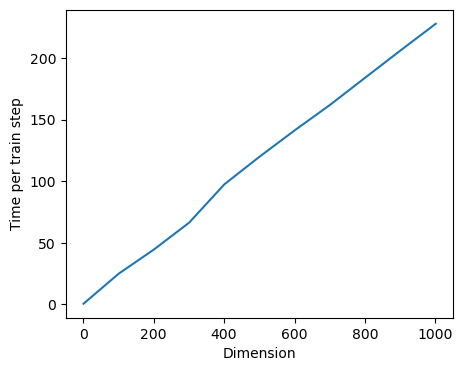

In [7]:
dual_time = torch.load('dual_dimension_complexity.pt')

# plotting dimension vs per training step time in seconds

plt.figure(figsize=(5,4))
plt.plot(dual_time['dim'], dual_time['time'])
plt.xlabel('Dimension')
plt.ylabel('Time per train step')


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]
2023-10-13 02:13:33,110 - INFO - Running 10 training steps takes 10.700846910476685s.


Dimension: 1, Time: 21.94770050048828


100%|██████████| 10/10 [03:19<00:00, 19.99s/it]
2023-10-13 02:16:53,001 - INFO - Running 10 training steps takes 199.87020874023438s.


Dimension: 101, Time: 828.204345703125


100%|██████████| 10/10 [06:19<00:00, 37.99s/it]
2023-10-13 02:23:13,069 - INFO - Running 10 training steps takes 379.8921136856079s.


Dimension: 201, Time: 1553.2601318359375


100%|██████████| 10/10 [10:02<00:00, 60.23s/it]
2023-10-13 02:33:15,715 - INFO - Running 10 training steps takes 602.3433756828308s.


Dimension: 301, Time: 2501.1513671875


100%|██████████| 10/10 [12:59<00:00, 78.00s/it]
2023-10-13 02:46:16,091 - INFO - Running 10 training steps takes 779.9534573554993s.


Dimension: 401, Time: 3250.375


100%|██████████| 10/10 [15:51<00:00, 95.20s/it]
2023-10-13 03:02:08,537 - INFO - Running 10 training steps takes 951.9974126815796s.


Dimension: 501, Time: 3985.735107421875


100%|██████████| 10/10 [18:46<00:00, 112.66s/it]
2023-10-13 03:20:55,669 - INFO - Running 10 training steps takes 1126.603909254074s.


Dimension: 601, Time: 4727.18798828125


100%|██████████| 10/10 [21:42<00:00, 130.25s/it]
2023-10-13 03:42:38,803 - INFO - Running 10 training steps takes 1302.4746911525726s.


Dimension: 701, Time: 5477.4326171875


100%|██████████| 10/10 [18:42<00:00, 112.24s/it]
2023-10-13 04:01:21,942 - INFO - Running 10 training steps takes 1122.382295370102s.


Dimension: 801, Time: 4812.177734375


100%|██████████| 10/10 [20:19<00:00, 121.97s/it]
2023-10-13 04:21:42,325 - INFO - Running 10 training steps takes 1219.7412869930267s.


Dimension: 901, Time: 5253.83837890625


100%|██████████| 10/10 [22:28<00:00, 134.90s/it]
2023-10-13 04:44:12,022 - INFO - Running 10 training steps takes 1348.967493057251s.


Dimension: 1001, Time: 5813.716796875


Text(0, 0.5, 'Time per train step')

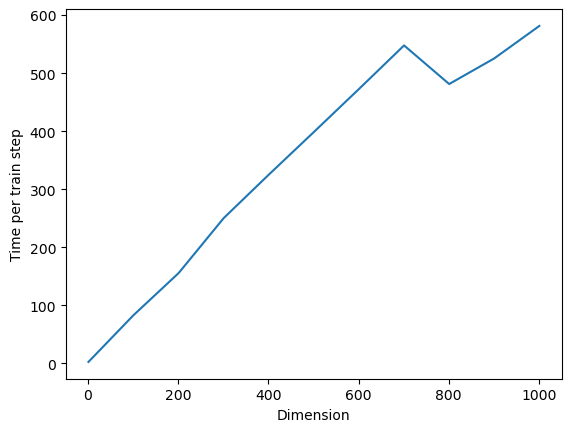

In [8]:
## Minmax Method ##

# running 10 training steps for each dimension

for i,d in enumerate(dim_list):
    
    # create dataset and dataloaders for dimension d
    
    args.data_shape = (int(d),)
    dataset_x, dataset_y = get_dataset(args, split="train")
    test_x, test_y = get_dataset(args, split="test")

    data_loader_X = DataLoader(dataset_x, batch_size=args.batch_size, shuffle=True)
    data_loader_Y = DataLoader(dataset_y, batch_size=args.batch_size, shuffle=True)
    
    # create potential flows for f and g

    tail_bound = torch.max(torch.cat([torch.abs(dataset_x.data), torch.abs(dataset_y.data)]))
    potential_flow_x = potential.ICRQ(tail_bound=args.tail_factor*tail_bound, num_bins=args.num_bins, data_shape=args.data_shape)
    potential_flow_y = potential.ICRQ(tail_bound=args.tail_factor*tail_bound, num_bins=args.num_bins, data_shape=args.data_shape)

    ## train

    OT_Trainer = flow.MinmaxOT_Trainer(potential_flow_x, potential_flow_y, args, dataset_x=data_loader_X, dataset_y=data_loader_Y, test_x=test_x, test_y=test_y)       
    
    start = time.perf_counter(), time.process_time()
    OT_Trainer.learn()
    stop = time.perf_counter(), time.process_time()

    time_list[i] = stop[1] - start[1]
    print(f'Dimension: {d}, Time: {time_list[i]}')
    
torch.save({'dim': dim_list, 'time': time_list/args.num_steps}, 'minmax_dim_complexity.pt')

plt.plot(dim_list, time_list/args.num_steps)
plt.xlabel('Dimension')
plt.ylabel('Time per train step')


### Sample Complexity

In [29]:
# Sample complexity

args.data_shape = (10,)
n_list = [int(5000*(n+1)) for n in range(20)]
time_list = np.zeros(len(n_list))

# create potential flows for f and g

potential_flow = potential.ICRQ(tail_bound=3, num_bins=args.num_bins, data_shape=args.data_shape)
potential_flow_x = potential.ICRQ(tail_bound=3, num_bins=args.num_bins, data_shape=args.data_shape)
potential_flow_y = potential.ICRQ(tail_bound=3, num_bins=args.num_bins, data_shape=args.data_shape)


100%|██████████| 100/100 [03:45<00:00,  2.25s/it]


Text(0, 0.5, 'Average time for objective evaluation')

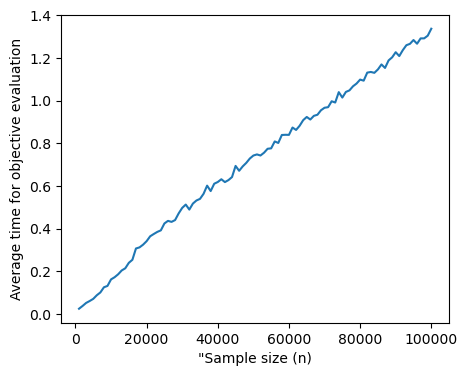

In [19]:
# running 10 training steps for each sample size

for i,n in enumerate(tqdm(n_list)):

    # create dataset and dataloaders for sample size n
    
    args.num_samples = int(n)
    dataset_x, dataset_y = get_dataset(args, split="train")
    test_x, test_y = get_dataset(args, split="test")

    data_loader_X = DataLoader(dataset_x, batch_size=args.batch_size, shuffle=True)
    data_loader_Y = DataLoader(dataset_y, batch_size=args.batch_size, shuffle=True)

    # train 

    OT_Trainer = flow.DualOT_Trainer(potential_flow, args, dataset_x=data_loader_X, dataset_y=data_loader_Y, test_x=test_x, test_y=test_y)
    
    start = time.perf_counter(), time.process_time()
    OT_Trainer.objective(dataset_x.data, dataset_y.data)
    stop = time.perf_counter(), time.process_time()
    
    time_list[i] = stop[1]-start[1]

torch.save({'N': n_list, 'time': time_list/args.num_steps}, 'dual_N_complexity.pt')

# plotting dimension vs per training step time in seconds

plt.figure(figsize=(5,4))
plt.plot(n_list, time_list/args.num_steps)
plt.xlabel('"Sample size (n)')
plt.ylabel('Average time for objective evaluation')

N: torch.Size([5000, 10]), Time: 4.656770260000485
N: torch.Size([10000, 10]), Time: 8.326543976007088
N: torch.Size([15000, 10]), Time: 11.865263796993531
N: torch.Size([20000, 10]), Time: 15.583105869001884
N: torch.Size([25000, 10]), Time: 18.757995348001714
N: torch.Size([30000, 10]), Time: 22.522049788000004
N: torch.Size([35000, 10]), Time: 26.22766696599865
N: torch.Size([40000, 10]), Time: 29.605678443003853
N: torch.Size([45000, 10]), Time: 32.967214698001044
N: torch.Size([50000, 10]), Time: 37.19109356500121
N: torch.Size([55000, 10]), Time: 40.59047136699519
N: torch.Size([60000, 10]), Time: 42.977632731002814
N: torch.Size([65000, 10]), Time: 64.85694263900223
N: torch.Size([70000, 10]), Time: 55.13835417500377
N: torch.Size([75000, 10]), Time: 53.87645537299977
N: torch.Size([80000, 10]), Time: 57.68958358099917
N: torch.Size([85000, 10]), Time: 61.55015725499834
N: torch.Size([90000, 10]), Time: 64.38142658799916
N: torch.Size([95000, 10]), Time: 69.40483034700446
N: tor

Text(0, 0.5, 'Time per train step')

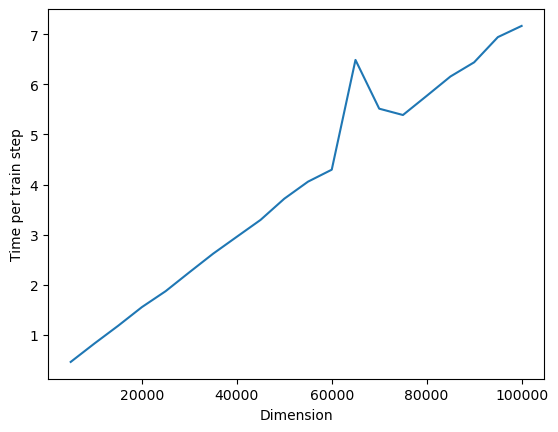

In [30]:
## Minmax Method ##

# evaluating the objective 10 times for each sample size

for i,n in enumerate(n_list):
    
    # create dataset and dataloaders for sample size n
    
    args.num_samples = int(n)
    dataset_x, dataset_y = get_dataset(args, split="train")
    test_x, test_y = get_dataset(args, split="test")

    data_loader_X = DataLoader(dataset_x, batch_size=args.batch_size, shuffle=True)
    data_loader_Y = DataLoader(dataset_y, batch_size=args.batch_size, shuffle=True)
    
    ## train

    OT_Trainer = flow.MinmaxOT_Trainer(potential_flow_x, potential_flow_y, args, dataset_x=data_loader_X, dataset_y=data_loader_Y, test_x=test_x, test_y=test_y)       
    
    start = time.perf_counter(), time.process_time()
    OT_Trainer.minimax_loss(dataset_x.data, dataset_y.data)
    stop = time.perf_counter(), time.process_time()
    
    time_list[i] = stop[1] - start[1]
    print(f'N: {dataset_x.data.shape}, Time: {time_list[i]}')
    
torch.save({'N': n_list, 'time': time_list/args.num_steps}, 'minmax_N_complexity.pt')

plt.plot(n_list, time_list/args.num_steps)
plt.xlabel('Dimension')
plt.ylabel('Time per train step')
